In [52]:
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd

Define paths and classes

In [53]:
base_path = "G:\\Yerb\\guayaki\\train\\"
train_path = "G:\\Yerb\\guayaki\\train\\"
validation_path = "G:\\Yerb\\guayaki\\validation\\"
src_path = "labeled\\"
csv_path = "data/files.csv"
classes = ["Cans", "Cans/Enlightenmint", "Cans/Revelberry", "Cans/Bluephoria", "Cans/Lemon", "Cans/Slim", "Cans/Slim/Gold", "Cans/Slim/Cranpom", "Cans/Slim/Blackberry", "Cans/Slim/Other", "Cans/Slim/GrapefruitGinger", "Cans/Slim/LimaLimon", "Cans/Other", "Bottles", "Bottles/Mint", "Bottles/Raspberry", "Bottles/Original", "Bottles/Passion", "Bottles/Other", "NoYerb"]
num_classes = len(classes)
validation_split = 0.1
img_width, img_height = 512, 512
batch_size = 2
lr = 0.001

Define the data denerator to augment our (lacking) training data. https://stackoverflow.com/questions/43086548/how-to-manually-specify-class-labels-in-keras-flow-from-directory

In [63]:
class DirectoryIteratorWithNames(DirectoryIterator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Removes the path prefix from the filenames
        self.filenames_np = np.array([f.split('\\')[-1] for f in self.filepaths])
        self.class_mode = None # so that we only get the images back

    def _get_batches_of_transformed_samples(self, index_array):
        return super()._get_batches_of_transformed_samples(index_array), self.filenames_np[index_array]

class MulticlassImageDataGenerator(ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Read classes from csv with the filename as the key using pandas
        df = pd.read_csv(csv_path)

        # Create a dictionary with the filename as the key a list of its classes as the value
        class_dict = dict(zip(df['Filename'], [label.split(',') for label in df['Label']]))

        # Create a list of the classes in the same order as the images
        class_list = [class_dict[filename.split('\\')[-1]] for filename in df['Filename'].tolist()]
        
        # Assign base classes
        self.class_list_augmented = []
        for class_list in class_list:
            augmented_list = set(class_list)
            for label in class_list:
                if label.startswith("Cans"):
                    augmented_list.add("Cans")
                    if label.startswith("Cans/Slim"):
                        augmented_list.add("Cans/Slim")
                elif label.startswith("Bottles"):
                    augmented_list.add("Bottles")
            self.class_list_augmented.append(list(augmented_list))

        # TODO: Remove and move validation split to an earlier cell
        # Move all labeled images to the folder train/labeled/
        # Validation_split chance to be moved to the validation folder
        for filename in df['Filename'].tolist():
            try:
                if np.random.rand() < validation_split:
                    os.rename(base_path + filename, validation_path + src_path + filename)
                else:
                    os.rename(base_path + filename, base_path + src_path + filename)
            except:
                pass

        # Convert the classes to ints
        Y = [[classes.index(label) for label in image_labels] for image_labels in self.class_list_augmented]

        # Multi-hot encode the classes
        mlb = MultiLabelBinarizer()
        Y = mlb.fit_transform(Y)

        # Save the filenames and labels in a dictionary
        self.labels = dict(zip(df['Filename'], Y))

    def _assign_labels(self, filenames):
        """
            Returns a list of labels for each filename
        """
        return [self.labels[filename] for filename in filenames]
        

    def multiclass_flow_from_directory(self, flow_from_directory_gen):
        """
            Returns a DirectoryIterator that returns both images and labels
        """
        # Get the filenames from the DirectoryIterator and only process the ones that have been labeled so far (ie, in the csv)
        # This is done by filtering the filenames with the keys of the labels dictionary

        for samples, filenames in flow_from_directory_gen:
            yield samples, self._assign_labels(filenames)

Create train and test image generators from these classes

In [64]:
train_datagen = MulticlassImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
        
validation_datagen = MulticlassImageDataGenerator(rescale=1./255)

train_directory_iterator = DirectoryIteratorWithNames(
    directory=train_path,
    image_data_generator=train_datagen,
    classes=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    shuffle=True,
    interpolation="bilinear")

validation_directory_iterator = DirectoryIteratorWithNames(
    directory=validation_path,
    image_data_generator=validation_datagen,
    classes=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    shuffle=True,
    interpolation="bilinear")

train_ds = train_datagen.multiclass_flow_from_directory(train_directory_iterator)
validation_ds = validation_datagen.multiclass_flow_from_directory(validation_directory_iterator)

Found 2416 images belonging to 1 classes.
Found 267 images belonging to 1 classes.


Augment the labels by assigning base classes (eg. Cans/Lemon gets the classes Cans and Cans/Lemon)

Multi-hot encode the labels

Compute class weights as our dataset is very imbalanced

In [70]:
# Compute class weights
class_list_np = np.array(train_datagen.class_list_augmented, dtype=object)
# Collapse the list of lists into a single list
class_list_np = np.concatenate(class_list_np)

class_weight_array = compute_class_weight(class_weight='balanced', classes=classes, y=class_list_np)
class_weights = dict(enumerate(class_weight_array))

Generate some samples to make sure everything matches up

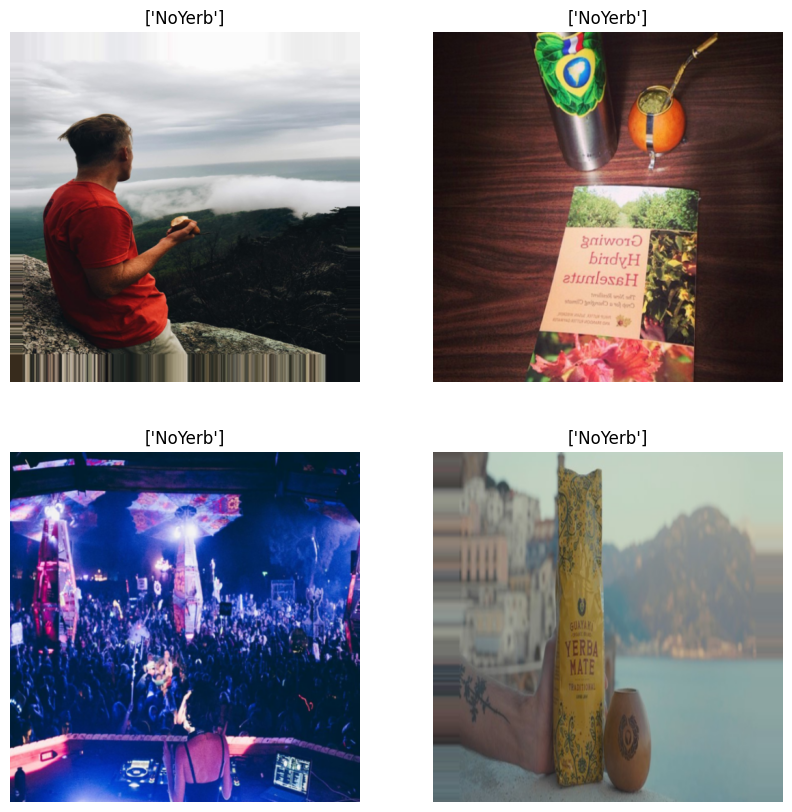

In [66]:
# Use matplotlib to print some examples from train_ds.
# Large spacing between images
fig, ax = plt.subplots(2, batch_size, figsize=(10, 10))
for j in range(2):
    images, labels = next(train_ds)
    for i in range(batch_size):
        ax[j, i].imshow(images[i])
        # Convert the one hot array back to text
        label_text = [classes[i] for i, label in enumerate(labels[i]) if label == 1]
        ax[j, i].set_title(label_text)
        ax[j, i].axis('off')
plt.show()

Define the CNN. For multi-hot encoded data we use sigmoid as our final activation function instead of softmax. https://stackoverflow.com/questions/44164749/how-does-keras-handle-multilabel-classification

In [72]:
if keras.backend.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=lr, momentum=0.9),
              metrics=['accuracy'])


d:\Stuff\YerbClassifier\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Fit using our class weights from earlier

In [73]:
model.fit(train_ds,
        batch_size=batch_size,
        epochs=25,
        validation_data=validation_ds,
        use_multiprocessing=True,
        class_weight=class_weights)

ValueError: `class_weight` is only supported for Models with a single output.